In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
import scipy.stats as st
np.random.seed(42)

In [3]:
# Edinburgh
from data_processing import read_edinburgh_data 
edinburgh_data, edinburgh_agent_ids = read_edinburgh_data()

/Users/kriis/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


reading:./OpenTraj/datasets/Edinburgh/annotations/tracks.01Sep.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2342/2342 [01:01<00:00, 37.94it/s]


Warning! too big dt in [Edinburgh]
finish


In [226]:
# Sample train and test data for pos_x and pos_y, each slice with num_steps length
def agent_data(data, agent_id):
    x = data["pos_x"].loc[data["agent_id"]==agent_id].values
    y = data["pos_y"].loc[data["agent_id"]==agent_id].values

    max_train_idx = len(x)-10
    
    return x, y, max_train_idx

# Sample train and test data for pos_x and pos_y, each slice with num_steps length
def generate_data(data, begin_idx, agent_id, num_steps=5):
    sample_x = data["pos_x"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values
    sample_y = data["pos_y"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values

    test_x = data["pos_x"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    test_y = data["pos_y"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    
    return sample_x, sample_y, test_x, test_y
    
def calculate_error(pred_x, pred_y, test_x, test_y):
    
    # FDE
    final_displacement_x = pred_x[-1] - test_x[-1]
    final_displacement_y = pred_y[-1] - test_y[-1]
    FDE = np.sqrt(final_displacement_x**2 + final_displacement_y**2)
    
    # MSE
    abs_error_x = pred_x - test_x
    abs_error_y = pred_y - test_y
    
    MSE = np.mean(np.square(abs_error_x)) + np.mean(np.square(abs_error_y))
    
    return FDE, MSE

    
def plot_many_trajectories(sample_x, sample_y, pred_xs, pred_ys, annotations = [], finalize_plot = True):
    #plt.figure(figsize=(10, 10))
    plt.axes().set_aspect('equal')
    
    plt.plot(sample_x, sample_y, c='green')
    plt.scatter(sample_x, sample_y, c='green')
    
    plt.scatter(x_data[0], y_data[0], c='blue')
    
    #plt.plot(x_data[start_idx+5:start_idx+10], y_data[start_idx+5:start_idx+10], c='orange')
    #plt.scatter(x_data[start_idx+5:start_idx+10], y_data[start_idx+5:start_idx+10], c='orange')
    
    for i in range(len(pred_xs)):
        plt.plot(np.append(sample_x[-1], pred_xs[i]), np.append(sample_y[-1], pred_ys[i]), c='orange')
        plt.scatter(pred_xs[i], pred_ys[i], c='orange')
        if len(annotations) > 0:
            plt.annotate(annotations[i], (pred_xs[i][-1], pred_ys[i][-1]))
    
    if finalize_plot:
        plt.show()

### Overview of different trajectories in the dataset

Agent id:  41


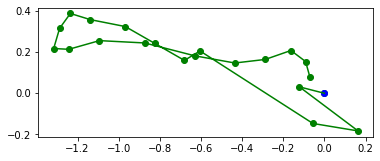

Agent id:  42


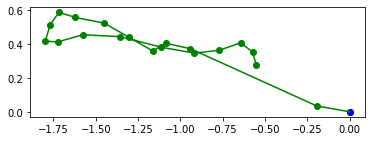

Agent id:  43


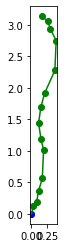

Agent id:  44


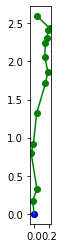

Agent id:  45


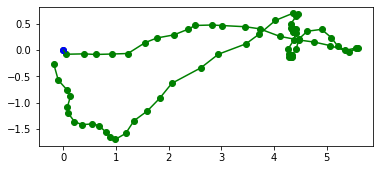

Agent id:  46


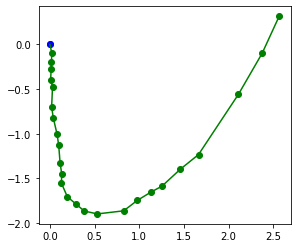

Agent id:  47


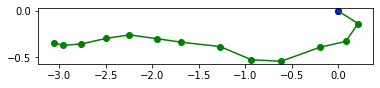

Agent id:  48


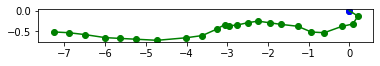

Agent id:  50


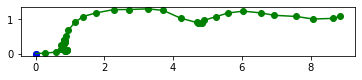

Agent id:  51


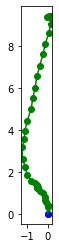

Agent id:  52


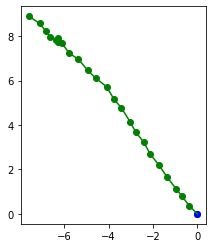

Agent id:  53


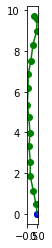

Agent id:  54


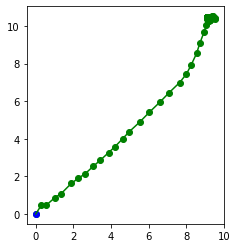

Agent id:  55


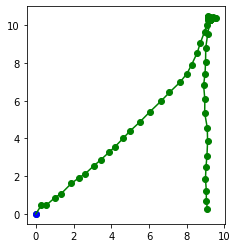

Agent id:  56


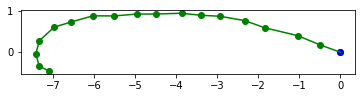

Agent id:  57


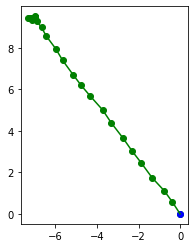

Agent id:  58


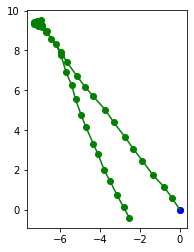

Agent id:  59


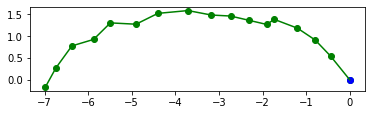

Agent id:  60


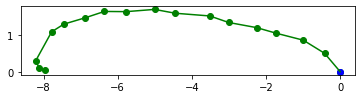

Agent id:  61


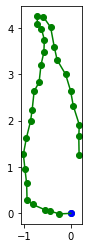

In [240]:
for agent_id in edinburgh_agent_ids[40:60]:
    x_data, y_data, max_train_idx = agent_data(edinburgh_data, agent_id)
    print("Agent id: ", agent_id)
    plot_many_trajectories(x_data, y_data, [], [], )

In [479]:
def avg_vel_const(sample_x, sample_y, noise_var):
    sample_vel_x = [(sample_x[i] - sample_x[i-1]) + np.random.normal(0, noise_var) for i in range(1, len(sample_x))]
    sample_vel_y = [(sample_y[i] - sample_y[i-1]) + np.random.normal(0, noise_var) for i in range(1, len(sample_y))]
    
    avg_vel_x = np.mean(sample_vel_x)
    avg_vel_y = np.mean(sample_vel_y)
    
    pred_x = [sample_x[-1] + i*avg_vel_x for i in range(1, 6)]
    pred_y = [sample_y[-1] + i*avg_vel_y for i in range(1, 6)]
    
    return pred_x, pred_y

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

def avg_vel_and_rot_const(sample_x, sample_y, noise_var):
    sample_vel_x = [(sample_x[i] - sample_x[i-1]) + np.random.normal(0, noise_var) for i in range(1, len(sample_x))]
    sample_vel_y = [(sample_y[i] - sample_y[i-1]) + np.random.normal(0, noise_var) for i in range(1, len(sample_y))]
    
    all_angles = []
    for i in range(1, len(sample_vel_x)):
        prev_vel = [sample_vel_x[i-1], sample_vel_y[i-1]]
        curr_vel = [sample_vel_x[i], sample_vel_y[i]]
        one_angle = np.math.atan2(np.linalg.det([prev_vel, curr_vel]),np.dot(prev_vel, curr_vel))   
        all_angles.append(one_angle)
    
    avg_angle = np.mean(all_angles)
    
    avg_vel_x = np.mean(sample_vel_x)
    avg_vel_y = np.mean(sample_vel_y)
    
    pred_x = [sample_x[-1] + i*avg_vel_x for i in range(1, 6)]
    pred_y = [sample_y[-1] + i*avg_vel_y for i in range(1, 6)]

    rot_pred_x = [pred_x[0]]
    rot_pred_y = [pred_y[0]]
    rot_pred_x[0] = sample_x[-1] + math.cos(avg_angle) * (rot_pred_x[0] - sample_x[-1]) - math.sin(avg_angle) * (rot_pred_y[0] - sample_y[-1])
    rot_pred_y[0] = sample_y[-1] + math.sin(avg_angle) * (rot_pred_x[0] - sample_x[-1]) + math.cos(avg_angle) * (rot_pred_y[0] - sample_y[-1])
    avg_vel_x = rot_pred_x[0] - sample_x[-1]
    avg_vel_y = rot_pred_y[0] - sample_y[-1]
    for i in range(1, 5):

        rot_pred_x.append(rot_pred_x[-1] + avg_vel_x)
        rot_pred_y.append(rot_pred_y[-1] + avg_vel_y)
        
        prev_x = rot_pred_x[i-1]
        cur_x = rot_pred_x[i]
        prev_y = rot_pred_y[i-1]
        cur_y = rot_pred_y[i]
        
        rot_x, rot_y = rotate((prev_x, prev_y), (cur_x, cur_y), avg_angle)
        
        rot_pred_x[i] = rot_x
        rot_pred_y[i] = rot_y
        
        # redefine the average velocity as it now has a new heading
        avg_vel_x = rot_x - prev_x
        avg_vel_y = rot_y - prev_y
    
    return rot_pred_x, rot_pred_y

### General goal illustration

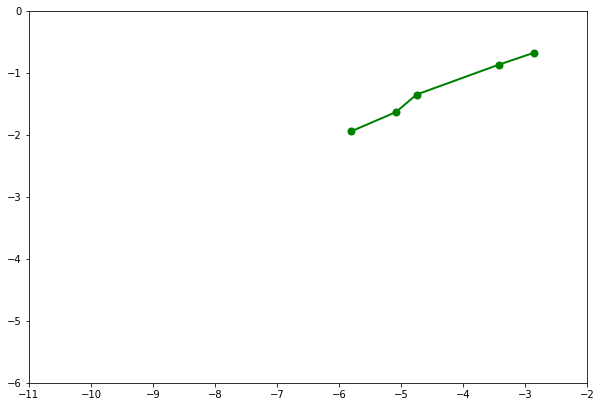

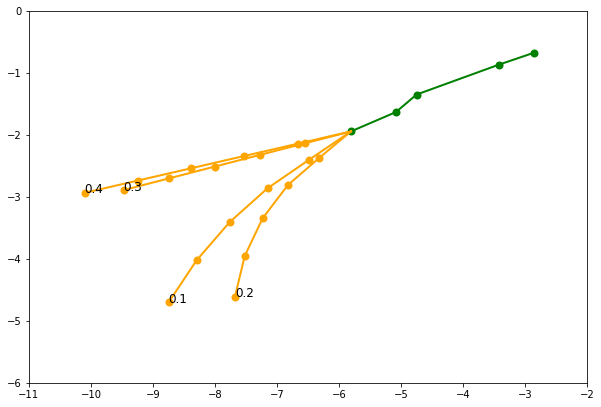

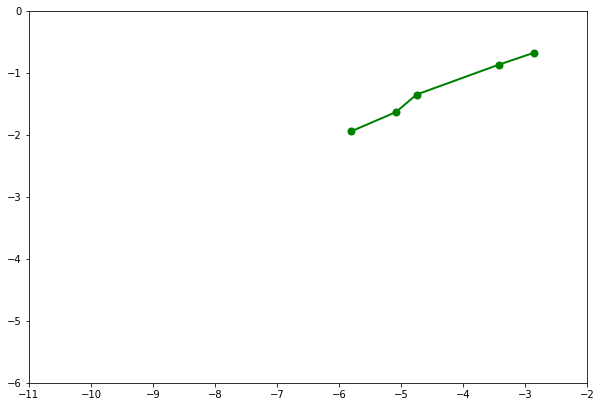

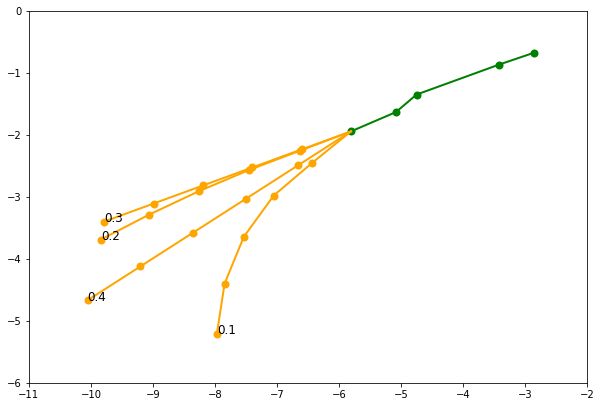

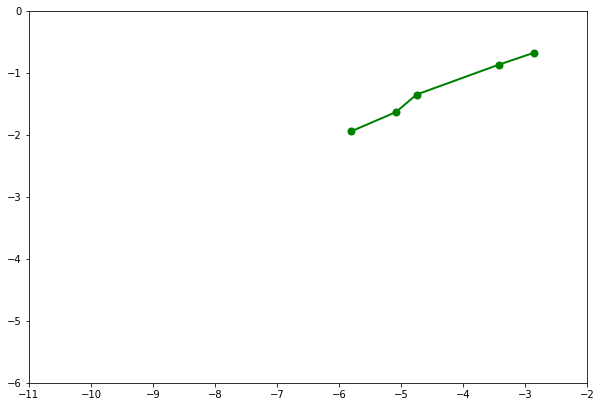

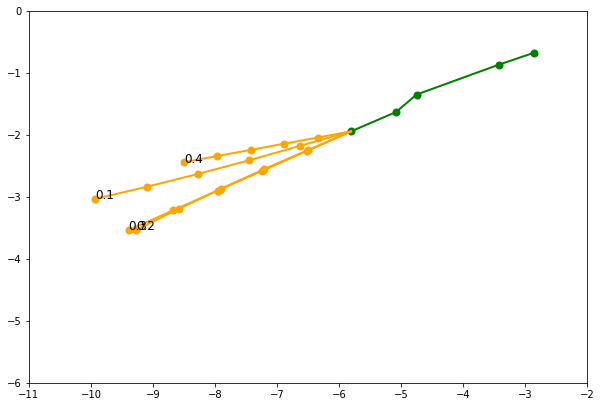

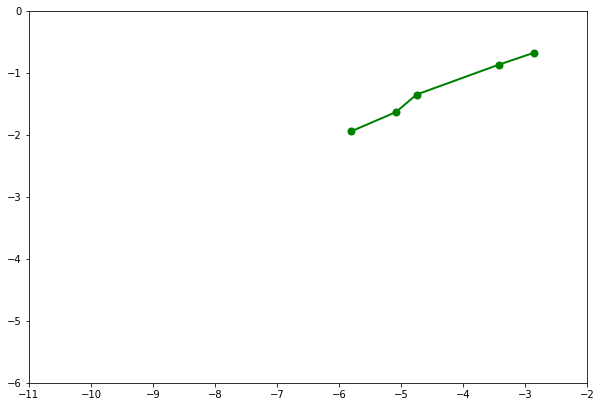

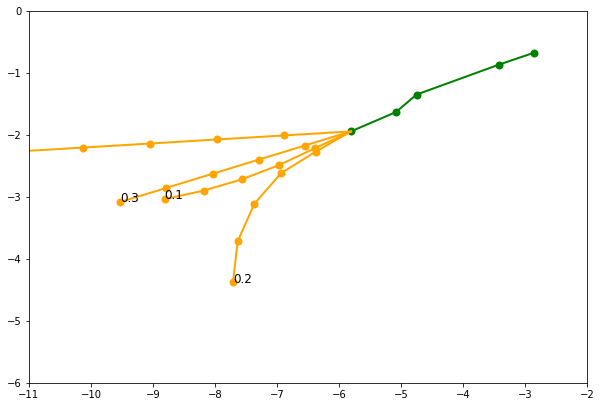

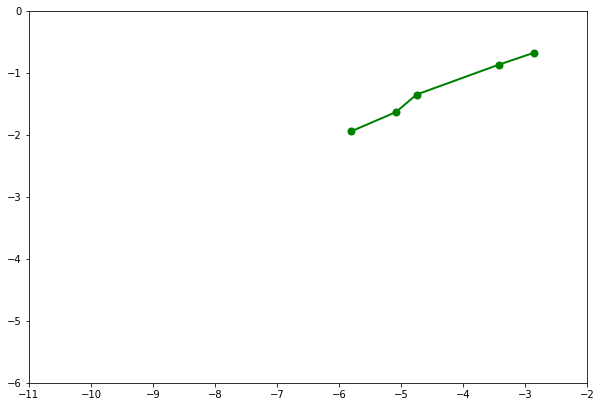

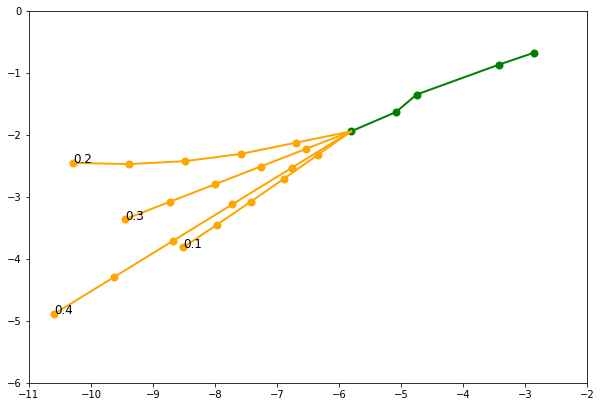

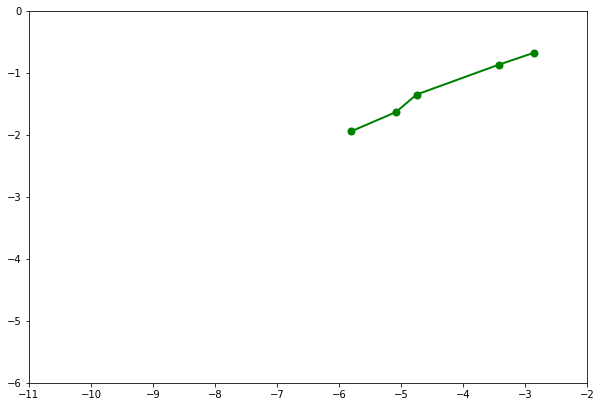

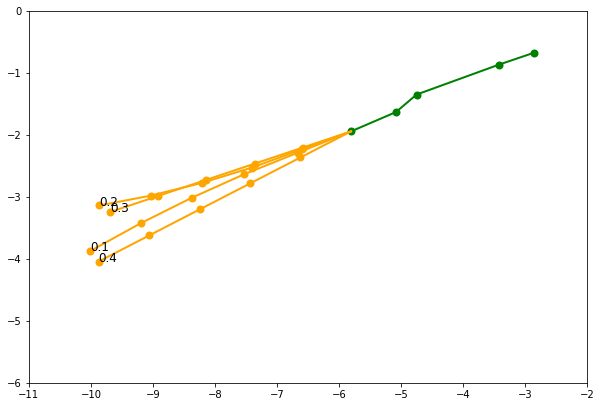

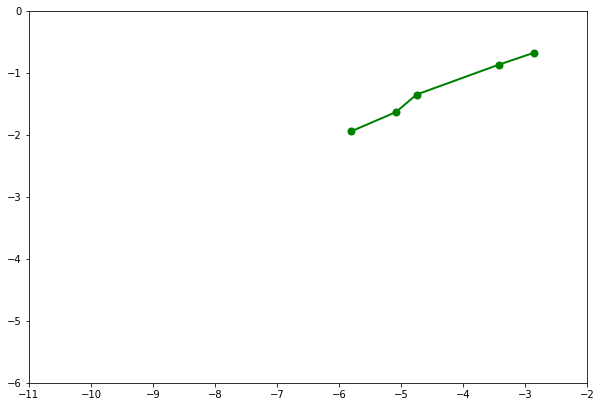

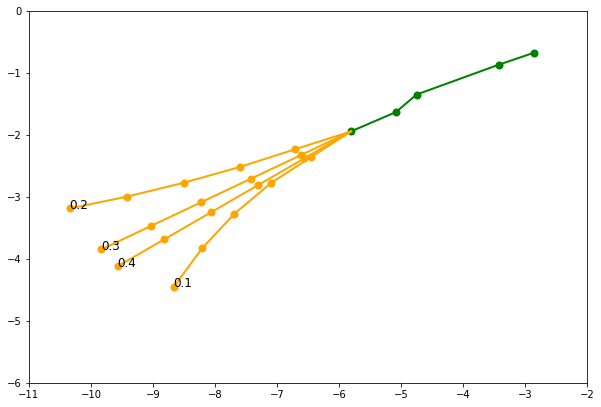

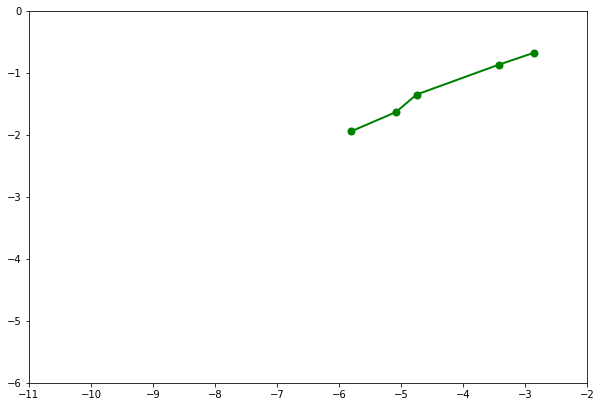

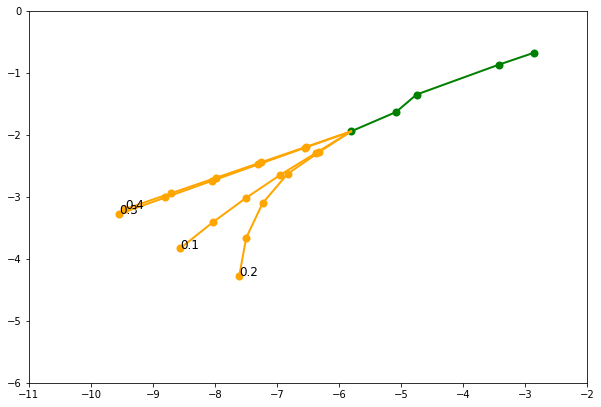

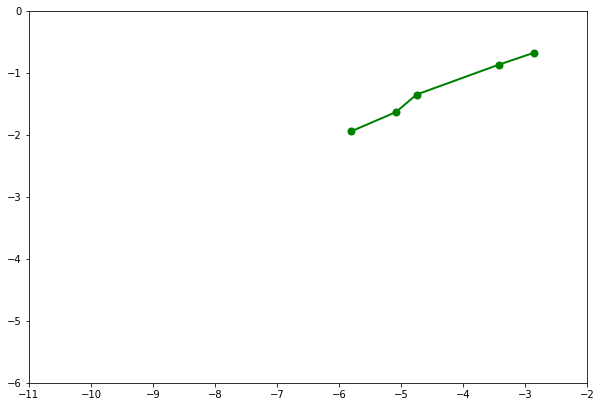

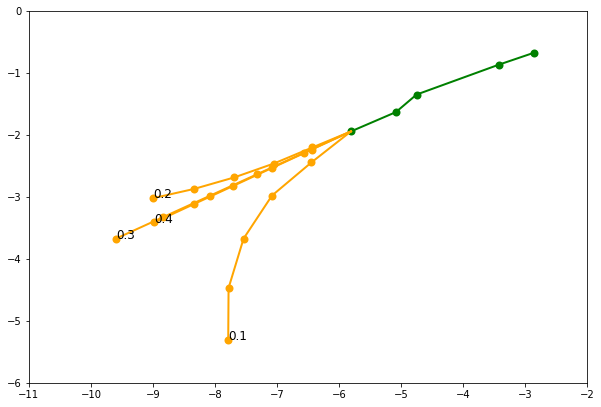

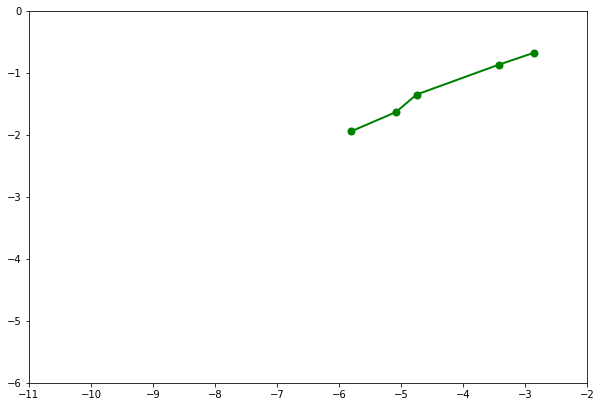

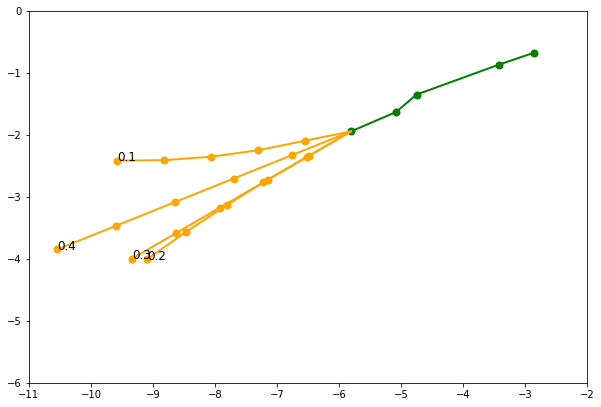

In [218]:
for i in range(10):
    for agent_id in edinburgh_agent_ids[:1]:
        x_data, y_data, max_train_idx = agent_data(edinburgh_data, agent_id)
        #random_start_idx = np.random.randint(0, max_train_idx)
        random_start_idx = 6
        sample_x, sample_y, test_x, test_y = generate_data(edinburgh_data, random_start_idx, agent_id, 5)

        avg_vel_const_1 = avg_vel_const(sample_x, sample_y, 0.1)
        avg_vel_const_2 = avg_vel_const(sample_x, sample_y, 0.3)
        rot_const_1 = avg_vel_and_rot_const(sample_x, sample_y, 0.2)
        rot_const_2 = avg_vel_and_rot_const(sample_x, sample_y, 0.2)

        #plot_predictions(sample_x, sample_y, test_x, test_y, pred_x, pred_y)

        trajectories_x = [
            avg_vel_const_1[0],
            avg_vel_const_2[0],
            rot_const_1[0],
            rot_const_2[0]
        ]

        trajectories_y = [
            avg_vel_const_1[1],
            avg_vel_const_2[1],
            rot_const_1[1],
            rot_const_2[1]
        ]

        plt.figure(figsize=(10, 10))
        plt.axes().set_aspect('equal')
        plt.xlim(-11, -2)
        plt.ylim(-6, 0)
        plt.plot(sample_x, sample_y, c='green', linewidth=2)
        plt.scatter(sample_x, sample_y, c='green', linewidth=2)
        plt.show()

        plt.figure(figsize=(10, 10))
        plt.axes().set_aspect('equal')
        plt.xlim(-11, -2)
        plt.ylim(-6, 0)
        plt.plot(sample_x, sample_y, c='green', linewidth=2)
        plt.scatter(sample_x, sample_y, c='green', linewidth=2)
        plt.scatter(x_data[0], y_data[0], c='blue', linewidth=2)

        annotations = [0.3, 0.4, 0.2, 0.1]
        for i in range(len(trajectories_x)):
            plt.plot(np.append(sample_x[-1], trajectories_x[i]), np.append(sample_y[-1], trajectories_y[i]), c='orange', linewidth=2)
            plt.scatter(trajectories_x[i], trajectories_y[i], c='orange', linewidth=2)
            plt.annotate(annotations[i], (trajectories_x[i][-1], trajectories_y[i][-1]), fontsize=12)
        plt.show()

        #plot_many_trajectories(sample_x, sample_y, trajectories_x, trajectories_y, random_start_idx, [0.3, 0.4, 0.2, 0.1])

### Train time vs predict time events

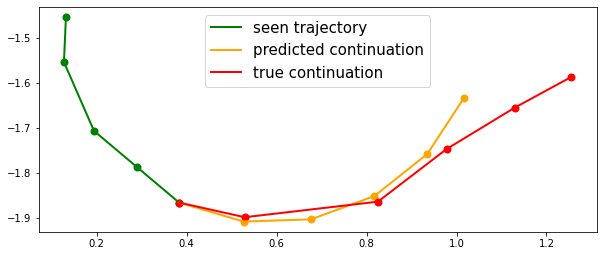

In [527]:
for agent_id in edinburgh_agent_ids[45:46]:

    x_data, y_data, max_train_idx = agent_data(edinburgh_data, agent_id)
    #plt.figure(figsize=(10, 10))
    #plt.axes().set_aspect('equal')
    #plt.plot(x_data, y_data)
    #plt.show()
    #random_start_idx = np.random.randint(0, max_train_idx)
    random_start_idx = 11
    sample_x, sample_y, test_x, test_y = generate_data(edinburgh_data, random_start_idx, agent_id, 5)

    avg_vel_const_1 = avg_vel_const(sample_x, sample_y, 0.1)
    avg_vel_const_2 = avg_vel_const(sample_x, sample_y, 0.3)
    rot_const_1 = avg_vel_and_rot_const(sample_x, sample_y, 0.1)
    rot_const_2 = avg_vel_and_rot_const(sample_x, sample_y, 0.2)

    #plot_predictions(sample_x, sample_y, test_x, test_y, pred_x, pred_y)

    trajectories_x = [
        rot_const_1[0],
    ]

    trajectories_y = [
        rot_const_1[1],
    ]

    plt.figure(figsize=(10, 10))
    plt.axes().set_aspect('equal')
    #plt.xlim(-11, -2)
    #plt.ylim(-6, 0)
    plt.plot(sample_x, sample_y, c='green', linewidth=2, label='seen trajectory')
    plt.scatter(sample_x, sample_y, c='green', linewidth=2)

    for i in range(len(trajectories_x)):
        plt.plot(np.append(sample_x[-1], trajectories_x[i]), np.append(sample_y[-1], trajectories_y[i]), c='orange', linewidth=2, label='predicted continuation')
        plt.scatter(trajectories_x[i], trajectories_y[i], c='orange', linewidth=2)
        
        
    plt.plot(np.append(sample_x[-1], test_x), np.append(sample_y[-1], test_y), c='red', linewidth=2, label='true continuation')
    plt.scatter(np.append(sample_x[-1], test_x), np.append(sample_y[-1], test_y), c='red', linewidth=2)
    plt.legend(prop={'size': 15})
    plt.show()


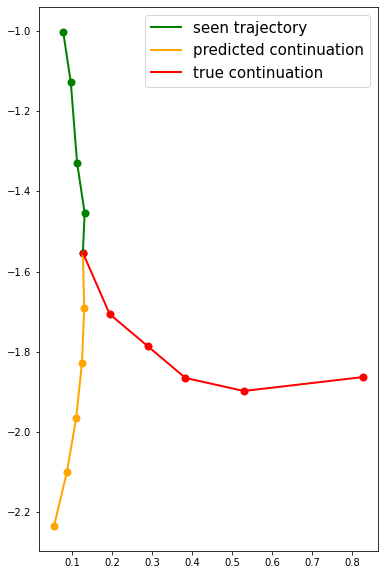

In [531]:
for agent_id in edinburgh_agent_ids[45:46]:

    x_data, y_data, max_train_idx = agent_data(edinburgh_data, agent_id)
    #plt.figure(figsize=(10, 10))
    #plt.axes().set_aspect('equal')
    #plt.plot(x_data, y_data)
    #plt.show()
    #random_start_idx = np.random.randint(0, max_train_idx)
    random_start_idx = 8
    sample_x, sample_y, test_x, test_y = generate_data(edinburgh_data, random_start_idx, agent_id, 5)

    avg_vel_const_1 = avg_vel_const(sample_x, sample_y, 0.1)
    avg_vel_const_2 = avg_vel_const(sample_x, sample_y, 0.3)
    rot_const_1 = avg_vel_and_rot_const(sample_x, sample_y, 0.0)
    rot_const_2 = avg_vel_and_rot_const(sample_x, sample_y, 0.2)

    #plot_predictions(sample_x, sample_y, test_x, test_y, pred_x, pred_y)

    trajectories_x = [
        rot_const_1[0],
    ]

    trajectories_y = [
        rot_const_1[1],
    ]

    plt.figure(figsize=(10, 10))
    plt.axes().set_aspect('equal')
    #plt.xlim(-11, -2)
    #plt.ylim(-6, 0)
    plt.plot(sample_x, sample_y, c='green', linewidth=2, label='seen trajectory')
    plt.scatter(sample_x, sample_y, c='green', linewidth=2)

    
    annotations = [0.3, 0.4, 0.2, 0.1]
    for i in range(len(trajectories_x)):
        plt.plot(np.append(sample_x[-1], trajectories_x[i]), np.append(sample_y[-1], trajectories_y[i]), c='orange', linewidth=2, label='predicted continuation')
        plt.scatter(trajectories_x[i], trajectories_y[i], c='orange', linewidth=2)
        
    plt.plot(np.append(sample_x[-1], test_x), np.append(sample_y[-1], test_y), c='red', linewidth=2, label='true continuation')
    plt.scatter(np.append(sample_x[-1], test_x), np.append(sample_y[-1], test_y), c='red', linewidth=2)
    plt.legend(prop={'size': 15})
    plt.show()
